# Simplification

Consider a curve which is represented as a series of points. The problem is to reduce the number of points in the series. 

The Ramer–Douglas–Peucker algorithm is widely known as a method which solves the problem. But let's tackle this problem with persistence.

## Imports

In [1]:
%cd ..

/home/snopoff/Documents/MIPT/Thesis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp_rec
from src.topology import topo_simplification

## Data

As data, let's consider several time series which represent the closing price of QQQ and SPY funds for 10-year long history and the price BTC-USD for 7-year long history.

In [29]:
btc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
2015-01-06,274.610992,287.553009,272.696014,286.188995,286.188995,23245700
2015-01-07,286.076996,298.753998,283.079010,294.337006,294.337006,24866800
...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479


Shapes of data are:  (2517,) (2517,) (2920,)


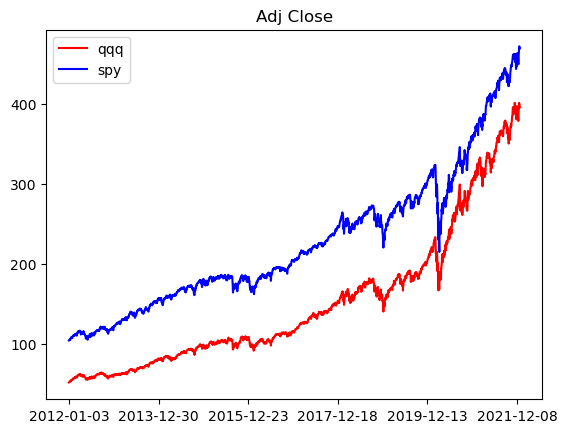

In [32]:
qqq = pd.read_csv('notebooks/data/QQQ.csv').set_index('Date')
spy = pd.read_csv('notebooks/data/SPY.csv').set_index('Date')
btc = pd.read_csv('notebooks/data/BTC-USD.csv').set_index('Date')
qqq_close = qqq['Adj Close']
spy_close = spy['Adj Close']
btc_close = btc['Adj Close']
print('Shapes of data are: ', spy_close.shape, qqq_close.shape, btc_close.shape)
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(spy_close, c='b', label='spy')
plt.xticks(range(0,2517,500))
plt.title('Adj Close')
plt.legend(loc='best')

## Ramer-Douglas-Peucker

The Ramer-Douglas-Peucker algorithm does the following: given a curve that consists of the line segments, it looks for the similar curve with fewer points. The algorithm recursively divides the line. Initially it is given all the points between the first and last point. It automatically marks the first and last point to be kept. It then finds the point that is farthest from the line segment with the first and last points as end points; this point is obviously farthest on the curve from the approximating line segment between the end points


In [4]:
qqq_close_rdp = np.vstack([np.array(range(0,qqq_close.shape[0])), qqq_close.to_numpy()]).T
qqq_close_rdp.shape

(2517, 2)

In [22]:
qqq_rdp = rdp_rec(qqq_close_rdp, 12)
qqq_rdp.shape

(43, 2)

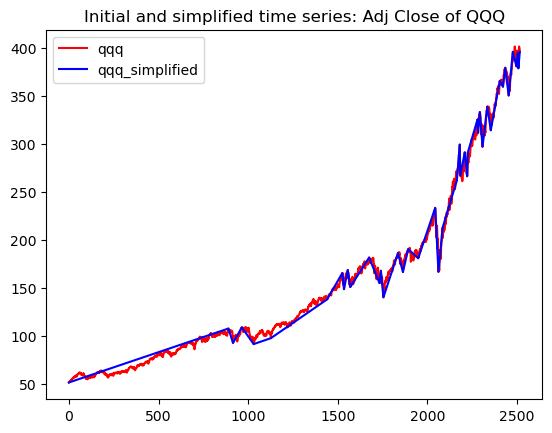

In [23]:
xticks_range = qqq_top.shape[0]
plt.plot(qqq_close_rdp[:,0], qqq_close_rdp[:,1], c='r', label='qqq')
plt.plot(qqq_rdp[:,0], qqq_rdp[:,1], c='b', label='qqq_simplified')
#plt.xticks(range(0, xticks_range, xticks_range // 5))
plt.xticks(range(0,2517,500))
plt.title('Initial and simplified time series: Adj Close of QQQ')
plt.legend(loc='best')

## Topological Simplification

In [24]:
qqq_top = topo_simplification(qqq_close, distance_to_diagonal=12)
qqq_top.shape

(44,)

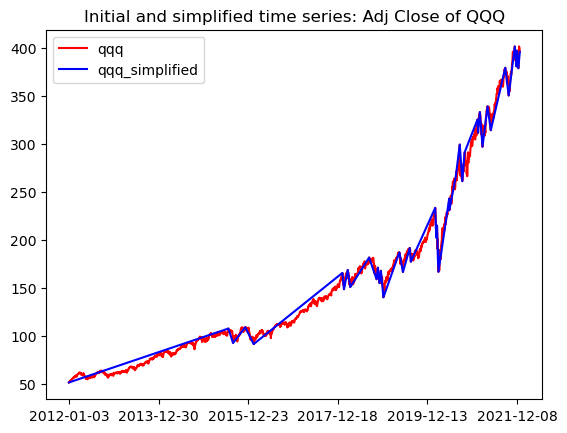

In [25]:
xticks_range = qqq_top.shape[0]
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(qqq_top, c='b', label='qqq_simplified')
#plt.xticks(range(0, xticks_range, xticks_range // 5))
plt.xticks(range(0,2517,500))
plt.title('Initial and simplified time series: Adj Close of QQQ')
plt.legend(loc='best')